**BERT**

We make use of BERT for fine-tuning.

In [ ]:
import tensorflow as tf
import transformers
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For the BERT model’s training, we cleverly combined all three datasets to prevent the domination of any singular dataset. We sampled 16000, 14780, and 17543 rows from the tweet sentiment, financial phrasebank, and chatgpt datasets respectively. This was saved as the “combined_output_csvSmall.csv” file.

In [158]:
# Viewing the data
data = "/content/drive/MyDrive/NLP_Project/Project/data/combined_output_csvSmall.csv"

df = pd.read_csv(data)
df = df.drop('Unnamed: 0', axis=1)
df = df[df['response'] != 1]
df['response'] = df['response'].replace(2, 1)
df.reset_index(drop = True, inplace = True)
# print(df)

In [92]:
df.response.unique()
# df.loc[:,"text"]

array([1, 0])

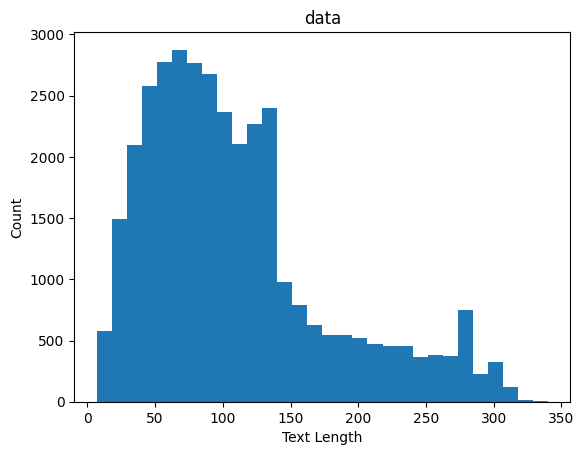

In [129]:
def display_histogram(data, title="data"):
    lengths = [len(review) for review in data.loc[:,"instruction"]]

    x = [length for length in lengths]

    plt.hist(x,bins=30)
    plt.ylabel("Count")
    plt.xlabel("Text Length")
    plt.title(title)
    plt.show()

display_histogram(df)

In [37]:
MAX_LENGTH = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [38]:
bert.summary()

Model: "tf_bert_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# defined a batch size and a split percentage of the data to be used for training
BATCH_SIZE = 2
SPLIT_PC = .80

END = int(len(df.index) * SPLIT_PC) - 1

In [95]:
training = df[:END+1]
testing = df[END+1:].reset_index()

print(training.shape)
print(testing.shape)

train_sentences = training.loc[:,"instruction"]
train_labels = training.loc[:,"response"]
test_sentences = testing.loc[:,"instruction"]
test_labels = testing.loc[:,"response"]

(27930, 2)
(6983, 3)


In [96]:
# Defined a function data_generator to calculate current index, append current sentence and label to batch and
# tokenize the batch_x, padding to MAX_LENGTH, and truncating to MAX_LENGTH
# We also convert labels to the appropriate tensor
def data_generator(sentences: np.array, labels: np.array, batch_size: int) -> (dict, tf.Tensor):
    i = 0
    while True:
        batch_x = []
        batch_y = []

        for j in range(batch_size):
            current_index = i * batch_size + j

            if current_index >= len(sentences):
                i = 0
                current_index = 0
            batch_x.append(sentences[current_index])
            batch_y.append(labels[current_index])

        i += 1

        batch_x = tokenizer(batch_x, return_tensors="tf", padding='max_length', truncation=True, max_length=MAX_LENGTH)

        batch_y = tf.convert_to_tensor(batch_y)

        yield dict(batch_x), batch_y

train_data = data_generator(train_sentences,train_labels,BATCH_SIZE)
test_data = data_generator(test_sentences,test_labels,BATCH_SIZE)

In [97]:
tmp_batch_x,tmp_batch_y = next(train_data)

print(tmp_batch_x['input_ids'].shape)
print(tmp_batch_y.shape)

(2, 128)
(2,)


In [98]:
train_labels = train_labels.astype('float32')
test_labels = test_labels.astype('float32')


bert_model = TFBertModel.from_pretrained('bert-base-uncased',output_attentions = False,return_dict=False)

bert_model.trainable = False
model_ = tf.keras.Sequential([
    bert_model,
    tf.keras.layers.Lambda(lambda x: x[0][:,0,:]),
    tf.keras.layers.Dense(50,activation="relu"),
    tf.keras.layers.Dense(50,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [99]:
# Train model for 3 epochs
model_.fit(
    train_data,
    epochs=3,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_sentences)//BATCH_SIZE,
    validation_data=test_data,
    validation_steps=BATCH_SIZE*4,
    validation_batch_size=BATCH_SIZE
)

Epoch 1/3
13965/13965 [==============================] - 654s 46ms/step - loss: 0.5244 - accuracy: 0.7376 - val_loss: 0.4537 - val_accuracy: 0.6875
Epoch 2/3
13965/13965 [==============================] - 649s 46ms/step - loss: 0.4810 - accuracy: 0.7666 - val_loss: 0.5915 - val_accuracy: 0.8125
Epoch 3/3
13965/13965 [==============================] - 632s 45ms/step - loss: 0.4726 - accuracy: 0.7717 - val_loss: 0.5367 - val_accuracy: 0.7500


In [117]:
#test_sentences


0       A new post in ’That Was The Week'\nWill ChatGP...
1       2:30pm is so far away! Oh yeah going to the DM...
2       OH NO!!! I wanted to have a Mini-Gathering at ...
3       Let's use ChatGPT, React Native, and Next.js t...
4       Sales in Finland rose by 3.9 % and internation...
                              ...                        
6978    UPM-Kymmene has generated seventeen consecutiv...
6979                            HELLOOOOOOOOO EVERYONE!! 
6980    @MeaganOnlineNet Thanks girl  .. Glad you're b...
6981    ( ADP News ) - Oct 1 , 2008 - Finnish consulti...
6982    The power of ChatGPT is incredible. I asked it...
Name: instruction, Length: 6983, dtype: object

In [121]:
# Evaluate model on test data
evaluation_results = model_.evaluate(test_data, steps=len(test_sentences)//BATCH_SIZE)

print("Evaluation Results:", evaluation_results)
predictions = model_.predict(test_data, steps=len(test_sentences)//BATCH_SIZE)
binary_predictions = (predictions > 0.5).astype(int)

3491/3491 [==============================] - 159s 45ms/step - loss: 0.4327 - accuracy: 0.7965
Evaluation Results: [0.43271416425704956, 0.7964766621589661]
3491/3491 [==============================] - 158s 44ms/step


Epoch 1/3
13965/13965 [==============================] - 635s 45ms/step - loss: 0.4622 - accuracy: 0.7787 - val_loss: 0.6961 - val_accuracy: 0.6250
Epoch 2/3
13965/13965 [==============================] - 619s 44ms/step - loss: 0.4562 - accuracy: 0.7804 - val_loss: 0.2525 - val_accuracy: 0.9375
Epoch 3/3
13965/13965 [==============================] - 639s 46ms/step - loss: 0.4496 - accuracy: 0.7853 - val_loss: 0.4629 - val_accuracy: 0.7500


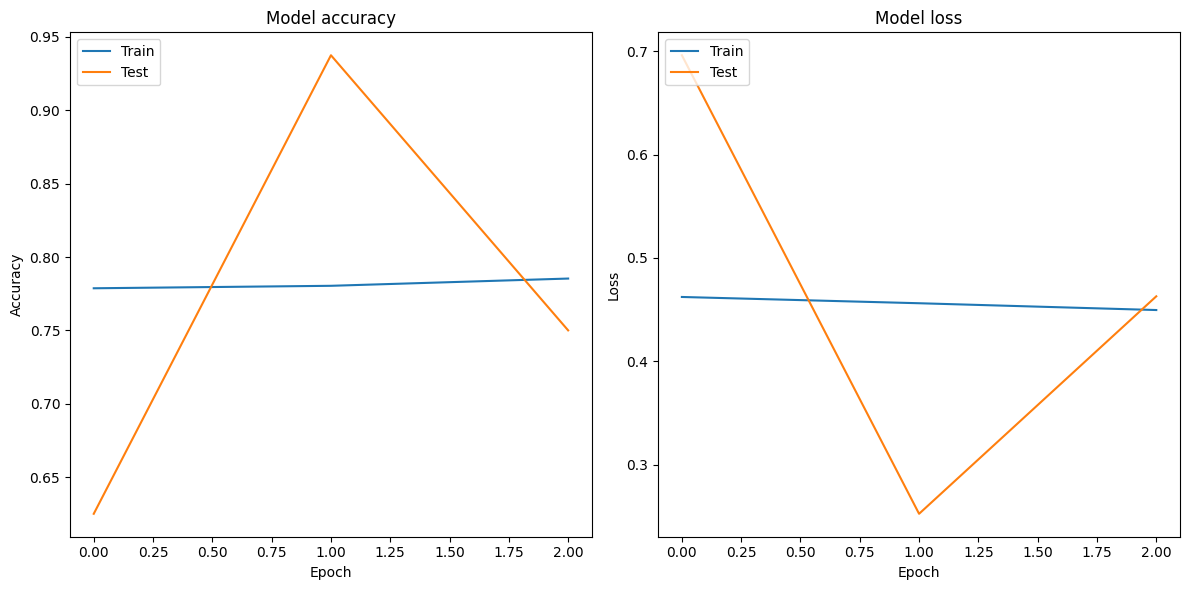

In [128]:
import matplotlib.pyplot as plt

# Fit model for 3 more epochs
history = model_.fit(
    train_data,
    epochs=3,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_sentences) // BATCH_SIZE,
    validation_data=test_data,
    validation_steps=BATCH_SIZE * 4,
    validation_batch_size=BATCH_SIZE
)



In [130]:
evaluation_results = model_.evaluate(test_data, steps=len(test_sentences)//BATCH_SIZE)

print("Evaluation Results:", evaluation_results)
predictions = model_.predict(test_data, steps=len(test_sentences)//BATCH_SIZE)
binary_predictions = (predictions > 0.5).astype(int)

3491/3491 [==============================] - 146s 42ms/step - loss: 0.4192 - accuracy: 0.8012
Evaluation Results: [0.41919392347335815, 0.8012030720710754]
3491/3491 [==============================] - 144s 41ms/step


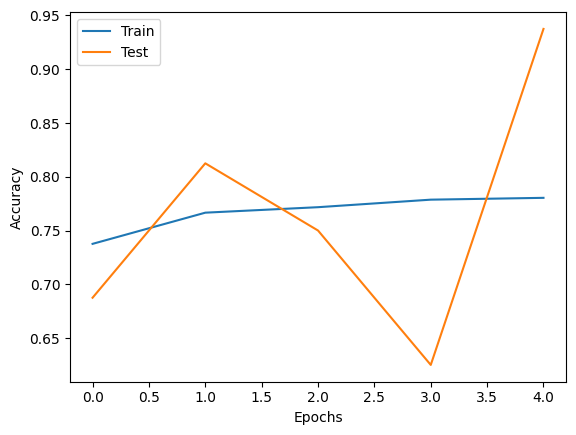

In [141]:
# Accuracy graph

ypoints = np.array([0.7376, 0.7666, 0.7717, 0.7787, 0.7804])
xpoints = np.array([0.6875, 0.8125, 0.7500, 0.6250, 0.9375])

plt.plot(ypoints, label = "Train")
plt.plot(xpoints, label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

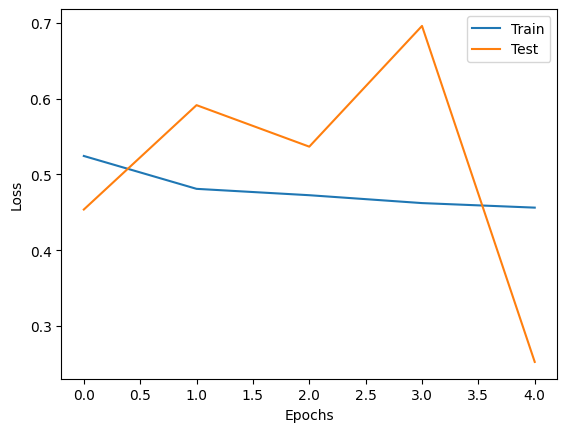

In [142]:
# Loss graph

ypoints = np.array([0.5244, 0.4810, 0.4726, 0.4622, 0.4562])
xpoints = np.array([0.4537, 0.5915, 0.5367, 0.6961, 0.2525])

plt.plot(ypoints, label = "Train")
plt.plot(xpoints, label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()